In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import os
import glob

In [69]:
import numpy as np

def expert_balance_loss_from_logits(
    logits: np.ndarray,
    top_k: int = 1,
    alpha: float = 1.0
) -> np.ndarray:
    """
    Compute per-layer expert-balance loss exactly as in your `add_perplexity_reg_standard`.

    Args:
      logits:  shape (L, T, N) — L layers, T tokens, N experts
      top_k:   K, number of experts selected per token
      alpha:   your self.perplexity_reg coefficient

    Returns:
      losses:  shape (L,), where for each layer l:
        loss[l] = alpha * sum_i f_i * P_i
    """
    L, T, N = logits.shape
    losses = np.zeros(L, dtype=np.float32)

    for layer in range(L):
        l = logits[layer]  # (T, N)

        # 1) softmax probabilities s[t,i]
        l_max = l.max(axis=1, keepdims=True)
        exp_l = np.exp(l - l_max)
        s = exp_l / exp_l.sum(axis=1, keepdims=True)  # (T, N)

        # 2) P_i = mean_t s[t,i]
        P = s.mean(axis=0)  # (N,)

        # 3) pick top_k experts per token
        topk_idx = np.argpartition(-l, top_k-1, axis=1)[:, :top_k]  # (T, top_k)

        # 4) count assignments per expert
        counts = np.bincount(topk_idx.ravel(), minlength=N)  # (N,)

        # 5) f_i = counts * N / (T * top_k)
        f = counts * (N / (T * top_k))  # (N,)

        # 6) final loss
        losses[layer] = alpha * np.dot(f, P)

    return losses


def extract_load_balacing_layer(model_path: str, top_k: int, alpha: float):
    model_path_list = glob.glob(model_path)
    model_path_list.sort(key=lambda x: int(x.split("-")[-1].split(".")[0]))

    lb_loss_all = {}
    for i in range(len(model_path_list)):
        training_step = int(model_path_list[i].split("-")[-1].split(".")[0])
        logits = np.load(model_path_list[i])[:, :6000, :]
        lb_loss = expert_balance_loss_from_logits(logits, top_k=top_k, alpha=alpha)
        lb_loss_all[training_step] = lb_loss

    lb_loss_all = pd.DataFrame(lb_loss_all)
    
    return lb_loss_all

In [74]:
color_list = ["#E85B9C", "#C96FA8", "#B07FB2", "#9C8CBA", "#8C96C0", "#4BC0D8", "#46A4C1", "#428EAF", "#3F7CA0", 
              "#3C6E94", "#3A628B", "#313465", "#393962", "#574F57", "#76644C", "#8F7543", "#A3833C", "#F1B921"]
colors = sns.color_palette(color_list)
colors

[(0.9098039215686274, 0.3568627450980392, 0.611764705882353),
 (0.788235294117647, 0.43529411764705883, 0.6588235294117647),
 (0.6901960784313725, 0.4980392156862745, 0.6980392156862745),
 (0.611764705882353, 0.5490196078431373, 0.7294117647058823),
 (0.5490196078431373, 0.5882352941176471, 0.7529411764705882),
 (0.29411764705882354, 0.7529411764705882, 0.8470588235294118),
 (0.27450980392156865, 0.6431372549019608, 0.7568627450980392),
 (0.25882352941176473, 0.5568627450980392, 0.6862745098039216),
 (0.24705882352941178, 0.48627450980392156, 0.6274509803921569),
 (0.23529411764705882, 0.43137254901960786, 0.5803921568627451),
 (0.22745098039215686, 0.3843137254901961, 0.5450980392156862),
 (0.19215686274509805, 0.20392156862745098, 0.396078431372549),
 (0.2235294117647059, 0.2235294117647059, 0.3843137254901961),
 (0.3411764705882353, 0.30980392156862746, 0.3411764705882353),
 (0.4627450980392157, 0.39215686274509803, 0.2980392156862745),
 (0.5607843137254902, 0.4588235294117647, 0.2627450980392157),
 (0.6392156862745098, 0.5137254901960784, 0.23529411764705882),
 (0.9450980392156862, 0.7254901960784313, 0.12941176470588237)]

## 679M

In [77]:
smoe_679m = extract_load_balacing_layer("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe/model-*.npy", 8, 0.01)
smoe_679m_sigmoid = extract_load_balacing_layer("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_sigmoid/model-*.npy", 8, 0.01)
smoe_679m_shared = extract_load_balacing_layer("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_shared/model-*.npy", 6, 0.01)
smoe_679m_deepseek = extract_load_balacing_layer("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_deepseek/model-*.npy", 6, 0.01)

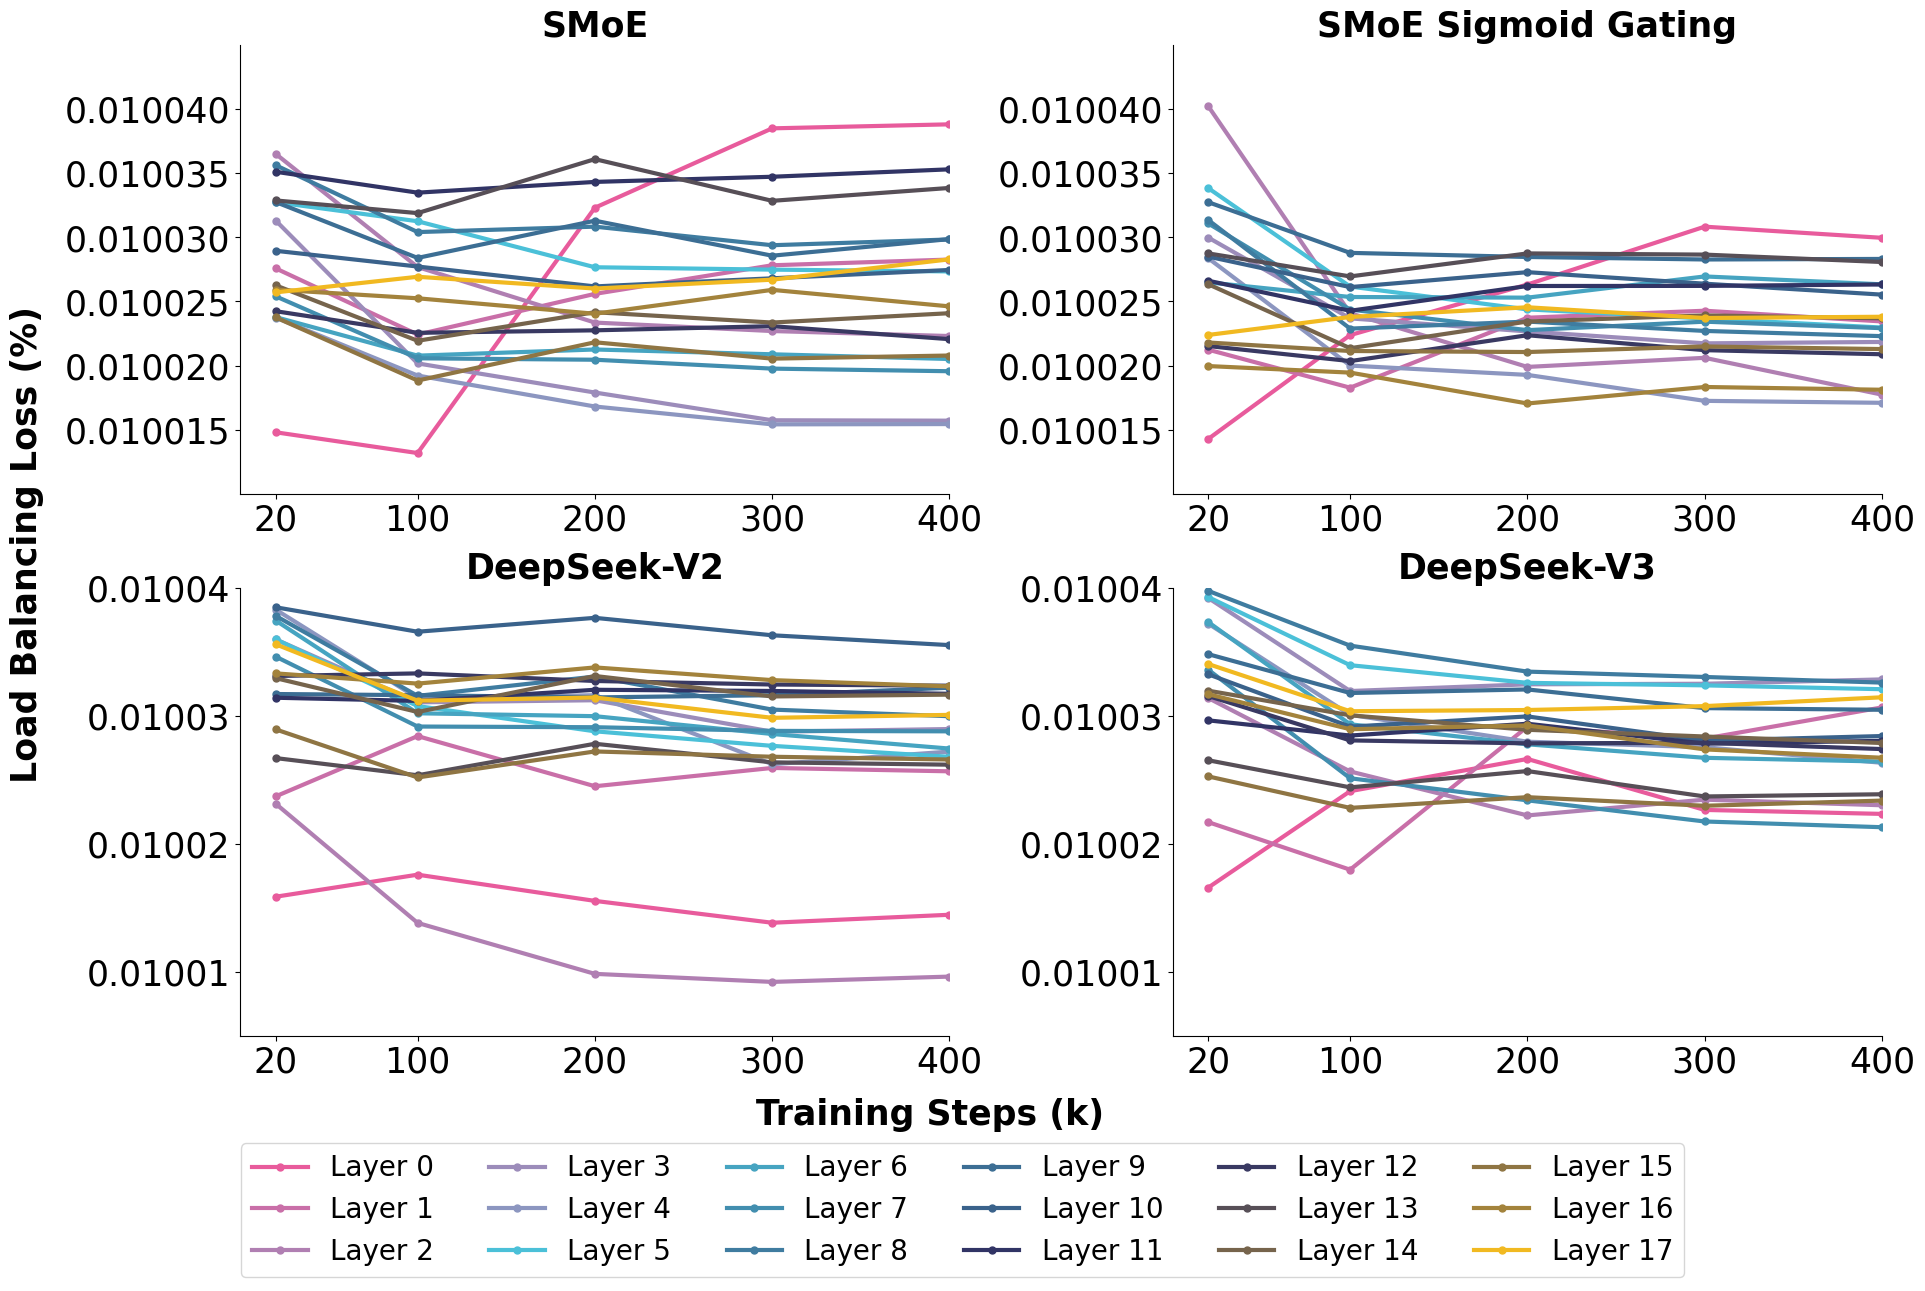

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=False, sharey=False)

# Set shared labels
fig.text(0.5, 0.17, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.75, 'Load Balancing Loss (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

xlims = [0, 400]
steps_idx_for_plot = [0, 4, 9, 14, 19]
steps_for_plot = [20 + 20 * i for i in steps_idx_for_plot]
xticks = steps_for_plot
yticks = [[0.010015, 0.01002, 0.010025, 0.01003, 0.010035, 0.01004], [0.0100, 0.01001, 0.01002, 0.01003, 0.01004, 0.01005]]
ylims = [[0.01001, 0.010045], [0.010005, 0.01004]]

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:  # apply for smoe and smoe_sigmoid
        for layer in range(18):
            values_smoe = smoe_679m.values[layer][steps_idx_for_plot]
            values_smoe_sigmoid = smoe_679m_sigmoid.values[layer][steps_idx_for_plot]
            
            l1, = ax[0].plot(steps_for_plot, values_smoe, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_smoe_sigmoid, linewidth=3, color=colors[layer], marker="o", markersize=5)
            lines.extend([l1])
            labels.extend([f"Layer {layer}"])
            
            ax[0].set_title("SMoE", fontsize=25, weight='bold')
            ax[1].set_title("SMoE Sigmoid Gating", fontsize=25, weight='bold')
            
    elif i == 1:
        for layer in range(18):
            values_shared = smoe_679m_shared.values[layer][steps_idx_for_plot]
            values_deepseek = smoe_679m_deepseek.values[layer][steps_idx_for_plot]
            
            ax[0].plot(steps_for_plot, values_shared, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_deepseek, linewidth=3, color=colors[layer], marker="o", markersize=5)
            
            ax[0].set_title("DeepSeek-V2", fontsize=25, weight='bold')
            ax[1].set_title("DeepSeek-V3", fontsize=25, weight='bold')

    ax[0].set_xticks(xticks)
    ax[0].set_xlim(xlims)
    ax[1].set_xticks(xticks)
    ax[1].set_xlim(xlims)
    
    ax[0].set_yticks(yticks[i])
    ax[0].set_ylim(ylims[i])
    ax[1].set_yticks(yticks[i])
    ax[1].set_ylim(ylims[i])
    
    ax[0].xaxis.set_tick_params(labelsize=25)
    ax[0].yaxis.set_tick_params(labelsize=25)
    ax[1].xaxis.set_tick_params(labelsize=25)
    ax[1].yaxis.set_tick_params(labelsize=25)
    
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
# Create a global legend in the right
fig.legend(lines, labels, loc='lower center', ncol=6, fontsize=20)

plt.tight_layout(rect=[0.06, 0.2, 1, 1.3])  # adjust bottom for legend space
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/balancing_loss/balancing_loss_each_layer_679m.pdf', format='pdf', bbox_inches='tight')
plt.show()


## 158M

In [86]:
smoe_158m = extract_load_balacing_layer("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe/model-*.npy", 8, 0.01)
smoe_158m_sigmoid = extract_load_balacing_layer("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_sigmoid/model-*.npy", 8, 0.01)
smoe_158m_shared = extract_load_balacing_layer("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_shared/model-*.npy", 6, 0.01)
smoe_158m_deepseek = extract_load_balacing_layer("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_deepseek/model-*.npy", 6, 0.01)

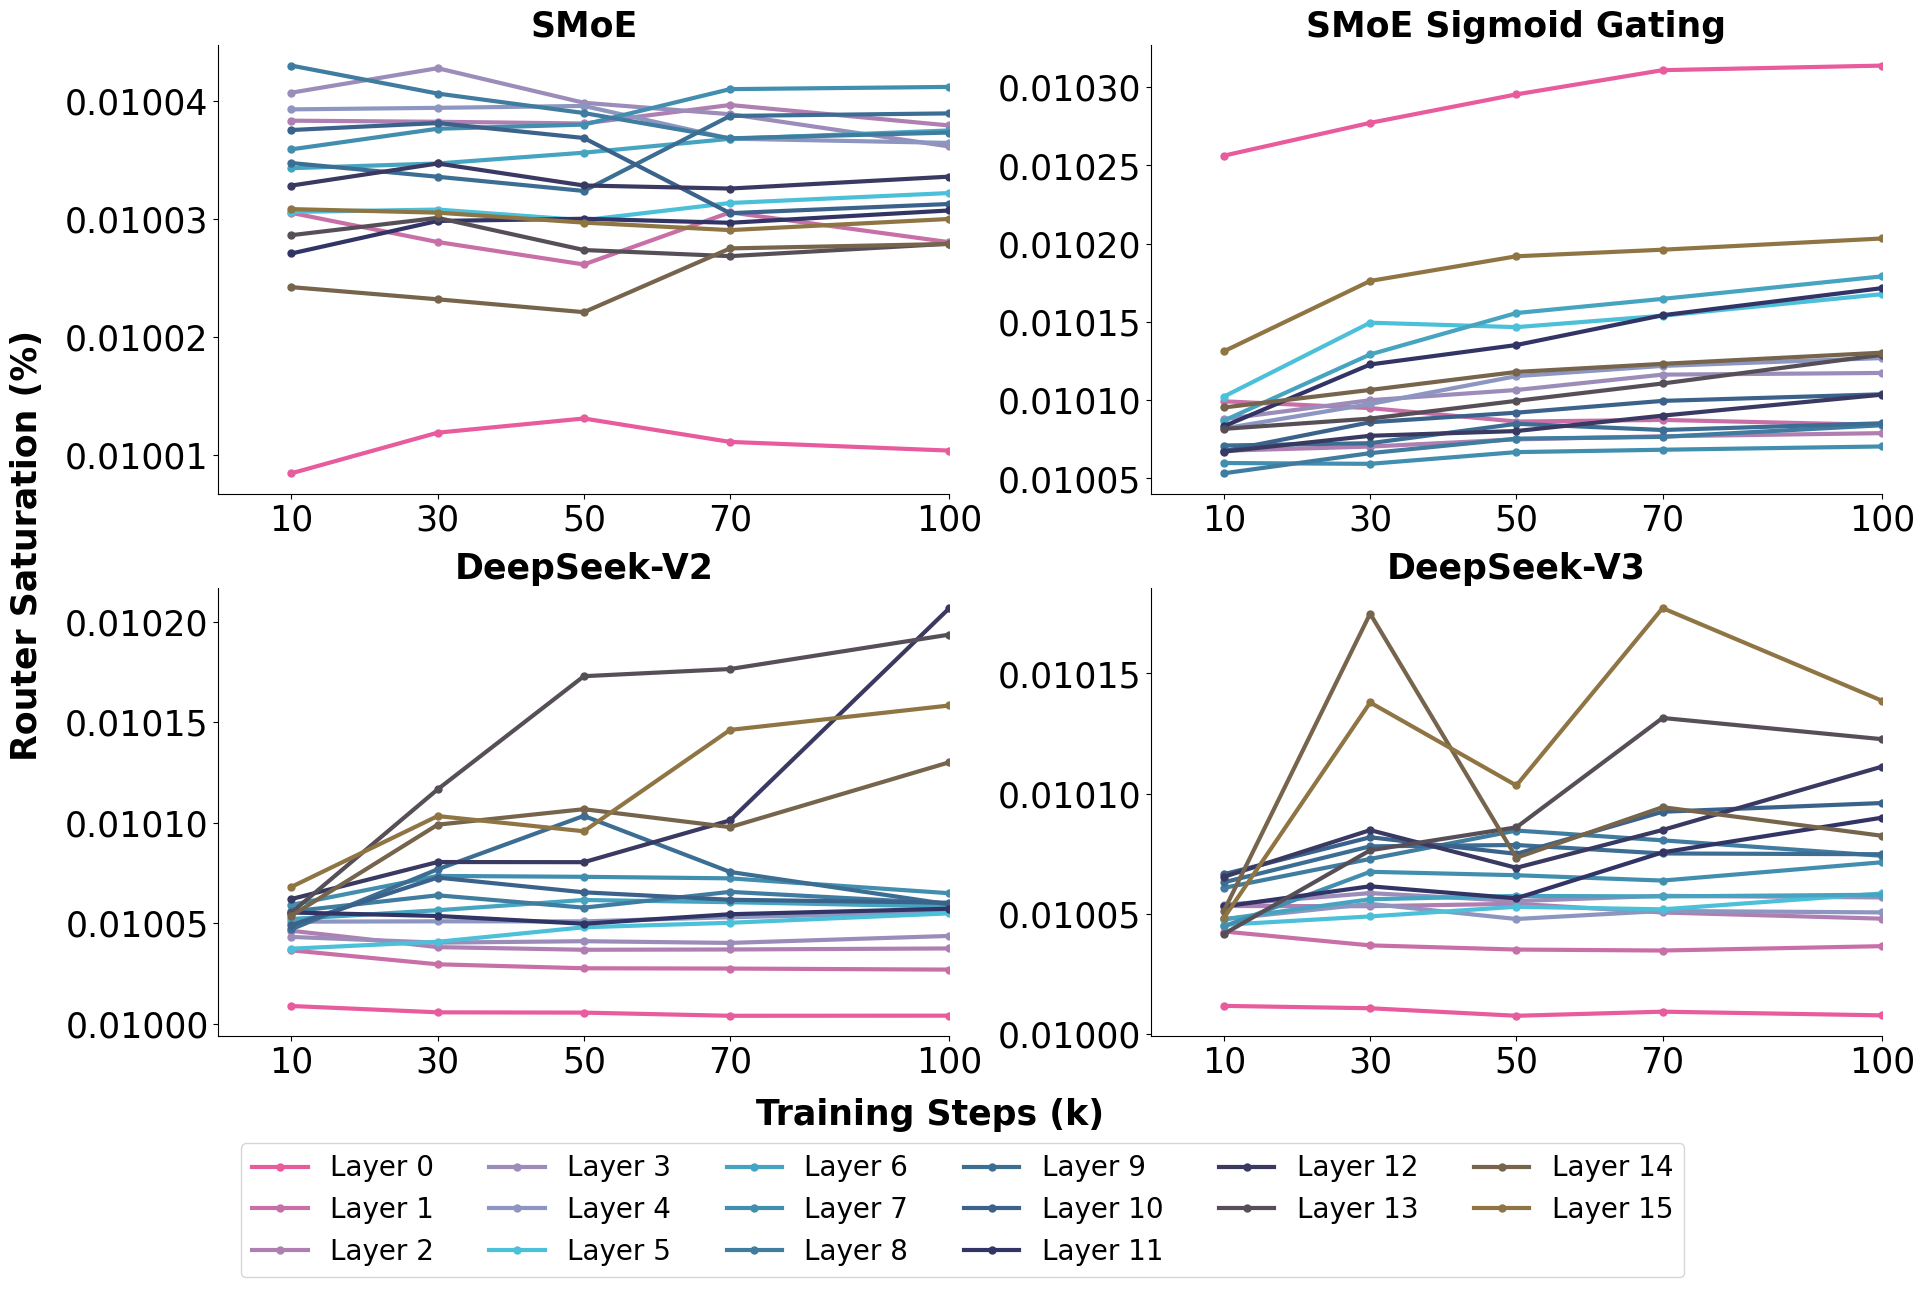

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=False, sharey=False)

# Set shared labels
fig.text(0.5, 0.17, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.75, 'Router Saturation (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

xlims = [0, 100]
steps_idx_for_plot = [0, 2, 4, 6, 9]
steps_for_plot = [10 + 10 * i for i in steps_idx_for_plot]
xticks = steps_for_plot
yticks = [[60, 70, 80, 90], [40, 50, 60, 70, 80, 90]]
ylims = [[55, 95], [38, 95]]

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:  # apply for smoe and smoe_sigmoid
        for layer in range(16):
            values_smoe = smoe_158m.values[layer][steps_idx_for_plot]
            values_smoe_sigmoid = smoe_158m_sigmoid.values[layer][steps_idx_for_plot]
            
            l1, = ax[0].plot(steps_for_plot, values_smoe, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_smoe_sigmoid, linewidth=3, color=colors[layer], marker="o", markersize=5)
            lines.extend([l1])
            labels.extend([f"Layer {layer}"])
            
            ax[0].set_title("SMoE", fontsize=25, weight='bold')
            ax[1].set_title("SMoE Sigmoid Gating", fontsize=25, weight='bold')
            
    elif i == 1:
        for layer in range(16):
            values_shared = smoe_158m_shared.values[layer][steps_idx_for_plot]
            values_deepseek = smoe_158m_deepseek.values[layer][steps_idx_for_plot]
            
            ax[0].plot(steps_for_plot, values_shared, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_deepseek, linewidth=3, color=colors[layer], marker="o", markersize=5)
            
            ax[0].set_title("DeepSeek-V2", fontsize=25, weight='bold')
            ax[1].set_title("DeepSeek-V3", fontsize=25, weight='bold')


    ax[0].set_xticks(xticks)
    ax[0].set_xlim(xlims)
    ax[1].set_xticks(xticks)
    ax[1].set_xlim(xlims)
    
    # ax[0].set_yticks(yticks[i])
    # ax[0].set_ylim(ylims[i])
    # ax[1].set_yticks(yticks[i])
    # ax[1].set_ylim(ylims[i])
    
    ax[0].xaxis.set_tick_params(labelsize=25)
    ax[0].yaxis.set_tick_params(labelsize=25)
    ax[1].xaxis.set_tick_params(labelsize=25)
    ax[1].yaxis.set_tick_params(labelsize=25)
    
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
# Create a global legend in the right
fig.legend(lines, labels, loc='lower center', ncol=6, fontsize=20)

plt.tight_layout(rect=[0.06, 0.2, 1, 1.3])  # adjust bottom for legend space
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/balancing_loss/balancing_loss_each_layer_158m.pdf', format='pdf', bbox_inches='tight')
plt.show()
